In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel
import QuarkTM
import pickle
import matplotlib

In [2]:
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

# Import data

In [3]:
folder = 'output/ThermoLowres_G=6.60L=0.400MG=1.60screen=4.00/'

In [4]:
folder = 'output/ThermoLowres_G=7.60L=0.300MG=1.60screen=2.00/'

In [5]:
trange = array([0.2, 0.3, 0.4, 0.5])

In [6]:
NFS = {
    'qa1' : 3, 'qa8' : 3, 'qq3' : 3, 'qq6' : 3, 'qg3' : 1, 'qg6' : 1, 'qg15' : 1,
    'gq3' : 3, 'gq6' : 3, 'gq15' : 3, 'gg1' : 1, 'gg16' : 1, 'gg27' : 1
}

In [7]:
pQs = []
pGs = []

ch_names_Q = ['qa1', 'qa8', 'qq3', 'qq6', 'qg3', 'qg6', 'qg15']
ch_names_G = ['gq3', 'gq6', 'gq15', 'gg1', 'gg16', 'gg27']

TMs_Q = []
TMs_G = []
Xs_Q = []
Xs_G = []
# Sigmas = []
SQs = []
SGs = []


for T in trange:
    qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
    erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)
    Gtab_Q = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
    
    Gtab_Q = 1/(1/Gtab_Q - 0*5e-2j)
    
    pQ = QuarkTM.Particle(0.5, qrange, erange, 
                         Gtab=Gtab_Q)
    pQs += [pQ]

    Gtab_G = np.loadtxt(folder + 'G_G_T=%.3f.dat'%T, dtype=complex)
    
    Gtab_G = 1/(1/Gtab_G - 0*5e-2j)
    
    pG = QuarkTM.Particle(1.4, qrange, erange, 
                         Gtab=Gtab_G, stat='b', d=16)
    pGs += [pG]
    
    
    SQ = np.loadtxt(folder + 'Q_S_T=%.3f.dat'%T, dtype=complex)
    
    SQs += [SQ]

    SG = np.loadtxt(folder + 'G_S_T=%.3f.dat'%T, dtype=complex)
    
    SGs += [SG]
    
    tms_Q = dict()
    sms_Q = dict()
    xms_Q = dict()
    for ch in ch_names_Q:
#         print(ch)
        _tm = np.loadtxt(folder + f'Q_TM_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        
        _x = np.loadtxt(folder + f'Q_X_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        tms_Q[ch] = _tm
        
#         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
        # sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
        #         + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))
        
        # sms[ch] = sigma
        xms_Q[ch] = _x

    tms_G = dict()
    sms_G = dict()
    xms_G = dict()

    for ch in ch_names_G:
#         print(ch)
        _tm = np.loadtxt(folder + f'G_TM_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        
        _x = np.loadtxt(folder + f'G_X_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        tms_G[ch] = _tm
        
#         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
        # sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
        #         + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))
        
        # sms[ch] = sigma
        xms_G[ch] = _x
        
    Xs_Q += [xms_Q]
    TMs_Q += [tms_Q]
    Xs_G += [xms_G]
    TMs_G += [tms_G]
    # Sigmas += [sms]

# Quasiparticle pressure

In [8]:
ps_Q = array([tm.OmQ_F(T, pt.iImG, pt.iReG) 
            for T, pt in zip(trange, pQs)])

In [9]:
ps_G = array([tm.OmQ_B(T, pt.iImG, pt.iReG) 
            for T, pt in zip(trange, pGs)])

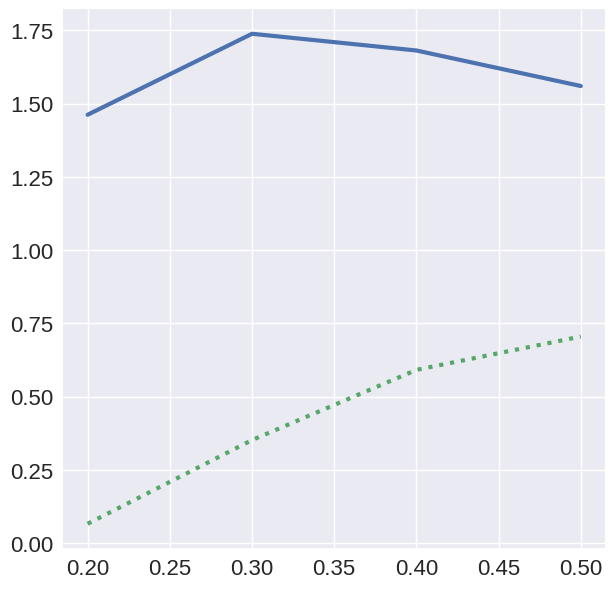

In [10]:
plt.plot(trange, 3*3*2*ps_Q/trange**4)
plt.plot(trange, 8*2*ps_G/trange**4, ls=':')

# Self-energy pressure 

In [11]:
ps_S_Q = []
ps_S_G = []

# ps_S2 = []

for T, pt, sig_tot in zip(trange, pQs, SQs):
#     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
    sigma = sig_tot
#     plt.plot(erange, real(sigma[:, 0]))
    iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
    iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))
    
    iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
    iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))
    
#     break
#     print(T)
    ps_S_Q += [tm.OmS_F(T, iImG, iReG, iImS, iReS)]

for T, pt, sig_tot in zip(trange, pGs, SGs):
#     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
    sigma = sig_tot
#     plt.plot(erange, real(sigma[:, 0]))
    iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
    iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))
    
    iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
    iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))
    
#     break
#     print(T)
    ps_S_G += [tm.OmS_B(T, iImG, iReG, iImS, iReS)]
#     ps_S2 += [tm.OmS2_F(T, iImG, iReG, iImS, iReS)]
ps_S_Q = array(ps_S_Q)
ps_S_G = array(ps_S_G)

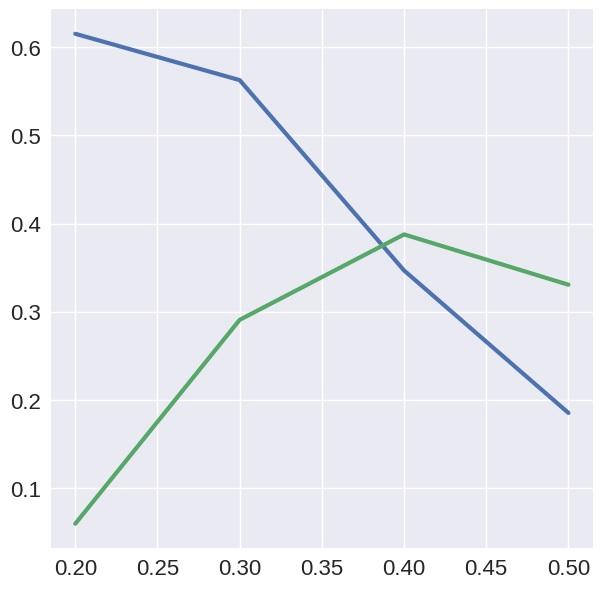

In [12]:
plt.plot(trange, 3*3*2*ps_S_Q/trange**4)
plt.plot(trange, 8*2*ps_S_G/trange**4)

In [13]:
from scipy.integrate import quad

Pfree_Q = array([quad(lambda z: z*z*T*log(1 + exp(-sqrt(0.5**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for T in trange])
Pfree_G = array([quad(lambda z: -z*z*T*log(1 - exp(-sqrt(1.4**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for T in trange])

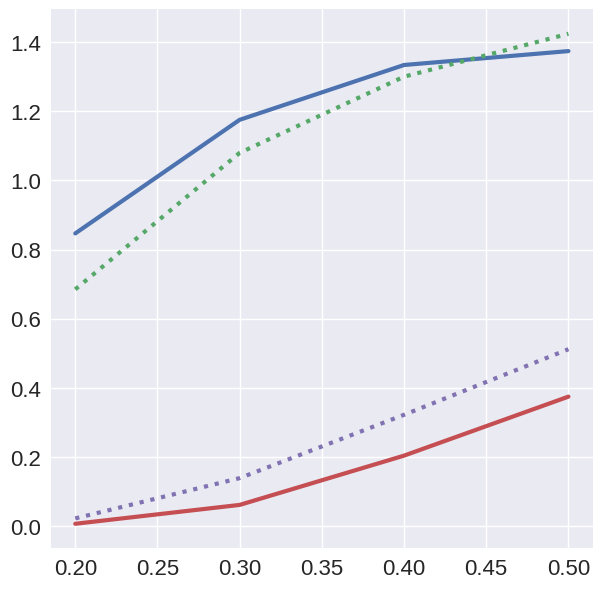

In [14]:
plt.plot(trange, 3*3*2*(ps_Q - ps_S_Q)/trange**4)
plt.plot(trange, 3*3*2*Pfree_Q/trange**4, ls=':')
plt.plot(trange, 8*2*(ps_G - ps_S_G)/trange**4)
plt.plot(trange, 8*2*Pfree_G/trange**4, ls=':')

# $\Phi$ pressure

## Quarks

In [15]:
keys_QQ = ['qa1', 'qa8', 'qq3', 'qq6']

keys_QG = ['qg3', 'qg6', 'qg15']

In [18]:
Phis_Q = []

LTs_QQ = dict()
LTs_QG = dict()
Vs = dict()

LSs_QQ = []
LSs_QG = []

for i, T in enumerate(trange[:]):
    xms = Xs_Q[i]
    tms = TMs_Q[i]

    LT_QQ = 0
    LT_QG = 0
    

    for k, x in xms.items():
        # x = xms[k]
        # if k == 'qq3':
        # print(NFS[k])
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        Vs[k] = v
        print(k, ds, da, Fa)
        lt = sign(v[0])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
        if k in keys_QQ:
            LT_QQ += lt
            LTs_QQ[k] = lt 
        elif k in keys_QG:
            LT_QG += lt
            LTs_QG[k] = lt 
        else:
            pass

    # break
    ImSTs = []
    ReSTs = []
    for LT, func, p2 in zip([LT_QQ, LT_QG], [tm.sigma_ff_onshell, tm.sigma_fb_onshell], [pQs[i], pGs[i]]):
        iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))
        #pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END

        iEps1 = tm.Interpolator(qrange, pQs[i].om0(qrange), 'linear')
        iEps2 = tm.Interpolator(qrange, p2.om0(qrange), 'linear')
        
        ST = array([
            pipe(erange) | p[lambda z: func(z, q, trange[i], iImLT, p2.R, 
                                           iEps1, iEps2)] * NTHR | END
                    for q in tqdm.tqdm(qrange)])
    
        ST = ST.transpose()
    
        ReST = []
    
        for res in tqdm.tqdm(ST.transpose()):
            iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
            ReST += [ReSigma]

        ReST = np.array(ReST).transpose()

        ImSTs += [ST]
        ReSTs += [ReST]

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ImSTs, axis=0)))
    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ReSTs, axis=0)))

    LSs_QQ += [1j*ST + ReST]
    
    pt = pQs[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis_Q += [Phi]

qa1 4.0 1.0 1.0
qa8 4.0 8.0 0.125
qq3 4.0 3.0 0.5
qq6 4.0 6.0 0.25
qg3 4.0 3.0 1.125
qg6 4.0 6.0 0.375
qg15 4.0 15.0 0.375


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0
qa8 4.0 8.0 0.125
qq3 4.0 3.0 0.5
qq6 4.0 6.0 0.25
qg3 4.0 3.0 1.125
qg6 4.0 6.0 0.375
qg15 4.0 15.0 0.375


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0
qa8 4.0 8.0 0.125
qq3 4.0 3.0 0.5
qq6 4.0 6.0 0.25
qg3 4.0 3.0 1.125
qg6 4.0 6.0 0.375
qg15 4.0 15.0 0.375


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0
qa8 4.0 8.0 0.125
qq3 4.0 3.0 0.5
qq6 4.0 6.0 0.25
qg3 4.0 3.0 1.125
qg6 4.0 6.0 0.375
qg15 4.0 15.0 0.375


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [174]:
keys_GG = ['gg1', 'gg16', 'gg27']
keys_GQ = ['gq3', 'gq6', 'gq15']

In [175]:
Phis_G = []

LTs_GG = dict()
LTs_GQ = dict()
Vs = dict()

LSs_GG = []
LSs_GQ = []

for i, T in enumerate(trange[:]):
    xms = Xs_G[i]
    tms = TMs_G[i]

    LT_GG = 0
    LT_GQ = 0
    

    for k, x in xms.items():
        # x = xms[k]
        # if k == 'qq3':
        # print(NFS[k])
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        Vs[k] = v
        print(k, ds, da, Fa)
        lt = sign(v[0])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
        if k in keys_GG:
            LT_GG += lt
            LTs_GG[k] = lt 
        elif k in keys_GQ:
            LT_GQ += lt
            LTs_GQ[k] = lt 
        else:
            pass

    # break
    ImSTs = []
    ReSTs = []
    for LT, func, p2 in zip([LT_GG, LT_GQ], [tm.sigma_bb, tm.sigma_bf], [pGs[i], pQs[i]]):
        iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))
        #pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
        
        ST = array([
            pipe(erange) | p[lambda z: func(z, q, trange[i], iImLT, p2.R)] * NTHR | END
                    for q in tqdm.tqdm(qrange)])
    
        ST = ST.transpose()
    
        ReST = []
    
        for res in tqdm.tqdm(ST.transpose()):
            iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
            ReST += [ReSigma]

        ReST = np.array(ReST).transpose()

        ImSTs += [ST]
        ReSTs += [ReST]

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ImSTs, axis=0)))
    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ReSTs, axis=0)))

    LSs += [1j*ST + ReST]
    
    pt = pGs[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis_G += [Phi]

gq3 4.0 3.0 1.125
gq6 4.0 6.0 0.375
gq15 4.0 15.0 0.375
gg1 4.0 1.0 2.25
gg16 4.0 16.0 1.125
gg27 4.0 27.0 0.75


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

gq3 4.0 3.0 1.125
gq6 4.0 6.0 0.375
gq15 4.0 15.0 0.375
gg1 4.0 1.0 2.25
gg16 4.0 16.0 1.125
gg27 4.0 27.0 0.75


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

gq3 4.0 3.0 1.125
gq6 4.0 6.0 0.375
gq15 4.0 15.0 0.375
gg1 4.0 1.0 2.25
gg16 4.0 16.0 1.125
gg27 4.0 27.0 0.75


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

gq3 4.0 3.0 1.125
gq6 4.0 6.0 0.375
gq15 4.0 15.0 0.375
gg1 4.0 1.0 2.25
gg16 4.0 16.0 1.125
gg27 4.0 27.0 0.75


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [176]:
Phis_G

[9.986229818649325e-07,
 3.577324313704278e-05,
 0.00021919238585793924,
 0.0006507860676730106]

In [177]:
Phis_Q

[7.451065220268236e-06,
 3.9959258218432125e-05,
 8.289705226004537e-05,
 0.0001368358010135099]

In [178]:
i = 0

In [19]:
Phis_Q = array(Phis_Q)

In [180]:
Phis_G = array(Phis_G)

In [181]:
Phis_Q

array([7.45106522e-06, 3.99592582e-05, 8.28970523e-05, 1.36835801e-04])

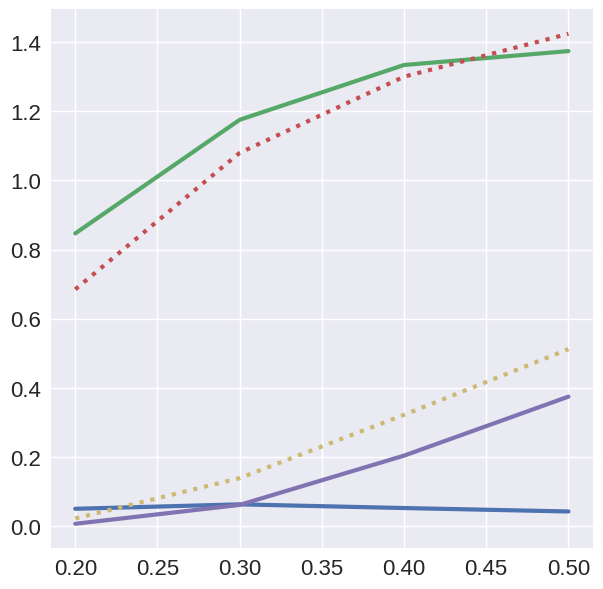

In [20]:
plt.plot(trange, (3*3*2*Phis_Q )/trange**4 / 2)
# plt.plot(trange, 8*2*Phis_G/trange**4 / 2)
plt.plot(trange, 3*3*2*(ps_Q - ps_S_Q)/trange**4)
plt.plot(trange, 3*3*2*Pfree_Q/trange**4, ls=':')
plt.plot(trange, 8*2*(ps_G - ps_S_G)/trange**4)
plt.plot(trange, 8*2*Pfree_G/trange**4, ls=':')

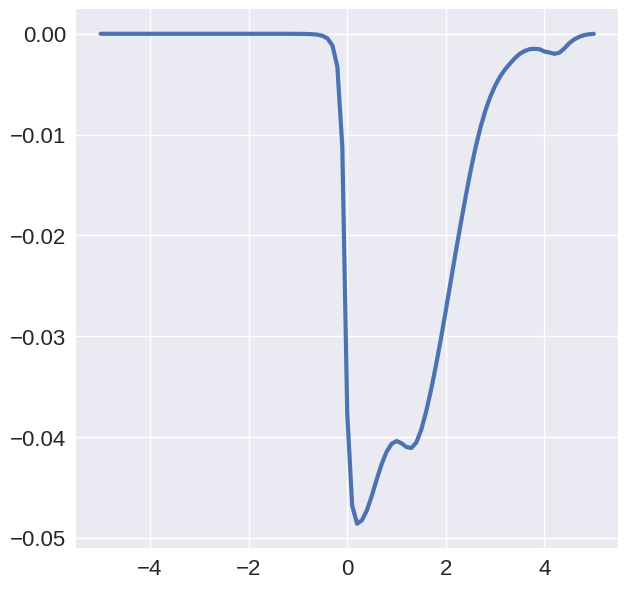

In [34]:
plt.plot(erange, imag(LSs[0][:, 0]))